In [1]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

function least_squares_solution(mat, y)
    inv(transpose(mat) * mat)*transpose(mat) * y
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

┌ Info: Precompiling QuantumOptics [6e0679c1-51ea-5a7c-ac74-d61b76210b0c]
└ @ Base loading.jl:1278


toarray (generic function with 2 methods)

In [2]:
time()

1.602195077462926e9

In [3]:
max_order = 20
discretization = 100
zernike_samples = []
ordering = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 == 0
            Zeven(ρ, ϕ) = R(n, m, ρ) * cos(m * ϕ)
            push!(zernike_samples, sample_across_unit_disk(Zeven, discretization)[3][:])
            push!(ordering, (n, m))
            if m !=0
                Zodd(ρ, ϕ) = R(n, m, ρ) * sin(m * ϕ)
                push!(zernike_samples, sample_across_unit_disk(Zodd, discretization)[3][:])
                push!(ordering, (n, -m))
            end
        end
    end
end
Z = reduce(hcat, zernike_samples);

In [4]:
σ1 = .1
σ2 = 1
amp = 1 # Used to make the small angle approximation work better.
function gaussian(σ1, σ2)
    function func(ρ, ϕ)
        x = ρ*cos(ϕ)
        y = ρ*sin(ϕ)
        amp * exp(-x^2/σ1^2 + -y^2/σ2^2)
    end
end
xx, yy, zz = sample_across_unit_disk(gaussian(σ1, σ2), discretization)
G = zz[:];

In [5]:
coefficients = least_squares_solution(Z, G)

231-element Array{BigFloat,1}:
  0.08504313016722482607742715654714324659424032484441359852818128589927245101606757
 -5.496616568976501312120961812958936898423948702103648576284243366153455691921383e-18
  5.485105589862841233628563078875790889711492907246334478305460101963767474591566e-78
 -0.1197229896580479499390019100765764253904217948000592155309866516276659907697968
 -0.1193317443853311646883388159718287295694141623526778325082358366714511191116121
  3.297731294116798046116538320412902820849272294922148768008700246291641386018978e-80
 -3.57992920090752104235102439728709505804412052919266738239794938357739367163477e-18
 -1.090590377227197627558859985603883466347595505006022106055544584947437526900822e-78
 -1.444243726543664178262247810741291607227227631117130462189016325741701589011436e-17
  1.591476557004937862255721610214850244451415045185805821028614300677888232525522e-78
  0.1170226318906687438938740945355895193687059935384675784050897629790012722736475
  0.18691022700814209504

In [6]:
reconstruction = zeros(discretization*discretization)
for (i, zernike_sample) in enumerate(zernike_samples)
    reconstruction += coefficients[i] * zernike_sample
end

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


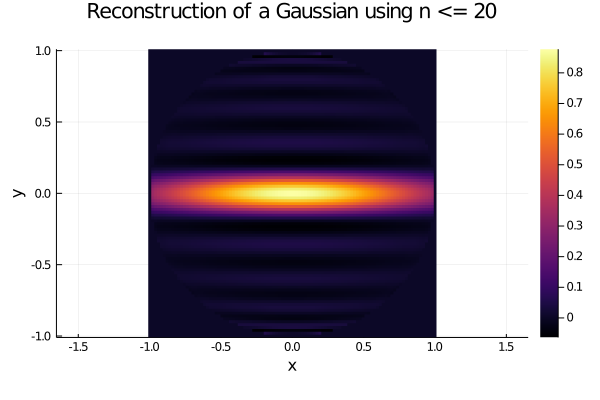

In [7]:
using Plots
plot(heatmap(xx, yy, reshape(reconstruction, (discretization, discretization))), aspectratio = true, xlabel="x", ylabel="y", title="Reconstruction of a Gaussian using n <= 20")

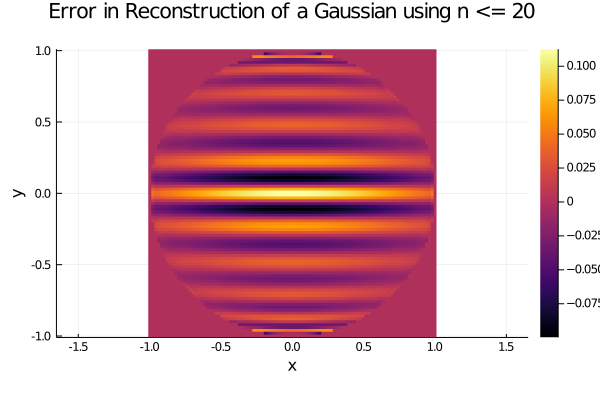

In [8]:
using Plots
diff = sample_across_unit_disk(gaussian(σ1,σ2), discretization)[3] - reshape(reconstruction, (discretization, discretization))
plot(heatmap(xx, yy, diff), aspectratio = true, xlabel="x", ylabel="y", title="Error in Reconstruction of a Gaussian using n <= 20")

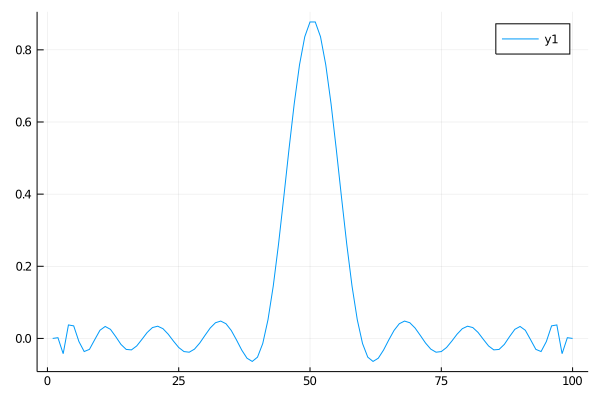

In [9]:
plot(reshape(reconstruction, (discretization, discretization))[:,Int64(discretization/2)])

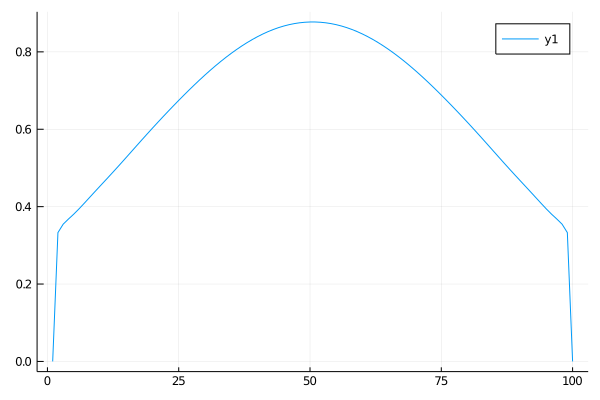

In [10]:
plot(reshape(reconstruction, (discretization, discretization))[Int64(discretization/2), :])

In [11]:
lookup = Dict(zip(ordering, coefficients));
zernike_even_coefficients = []
zernike_odd_coefficients = []
curr_even = []
curr_odd = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 != 0
            push!(curr_even, 0)
            push!(curr_odd, 0)
        else
            if m == 0
                push!(curr_even, lookup[(n, m)]/2)
                push!(curr_odd, lookup[(n, -m)]/2)
            else
                push!(curr_even, lookup[(n, m)])
                push!(curr_odd, lookup[(n, -m)])
            end
        end
    end
    push!(zernike_even_coefficients, curr_even)
    push!(zernike_odd_coefficients, curr_odd)
    curr_even = []
    curr_odd = []
end

In [25]:
function sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)
    """Apply all the zernike coefficients given, in order, for time T each."""
    orders = range(0, max(length(zernikeeven), length(zernikeodd)) - 1, step=1)
    function evaluator(ρ, ϕ)
        ψ = ψ0
        for order in orders
            print(order)
            μ = order * ω
            H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [], []
            _, ψ = @skiptimechecks timeevolution.master_dynamic(T, ψ, H)
            ψ = last(ψ)
        end
        ψ
    end
end

function gaussian_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = gaussian(σ1, σ2)(ρ, ϕ) * sigmaz(b), [], []
    evolution_time = π/2
    step_size = evolution_time/1
    T = [0.0:step_size:evolution_time;];
    _, ψ = timeevolution.master_dynamic(T, ψ0, H)
    last(ψ)
end

gaussian_spin_profile (generic function with 1 method)

In [65]:
Γ = 1/62
ω = 2*π*180E3
θ = -π/2;

In [66]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time =  50E-6
U = π/(evolution_time)
step_size = evolution_time
T = [0.0:step_size:evolution_time;];
sequential_exact_evolution = sequential_exact_evolution_evaluator_factory(ψ0, T, zernike_even_coefficients, zernike_odd_coefficients, U, θ, ω, b)

(::var"#evaluator#21"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},Array{Any,1},Array{Any,1},Float64,Float64,Float64,SpinBasis{1//2,Int64},StepRange{Int64,Int64}}) (generic function with 1 method)

In [67]:
spindown(b)

Ket(dim=2)
  basis: Spin(1/2)
 0.0 + 0.0im
 1.0 + 0.0im

In [68]:
using Plots
max_ρ = 1
min_ρ = .0
ρs = range(min_ρ, max_ρ, step=max_ρ/10)
angle = 0
target = []
for ρ in ρs
    print(ρ)
    Real.(expect(sigmax(b), sequential_exact_evolution(ρ, angle)))
end


0.0012345678910

LoadError: InterruptException:

0123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920

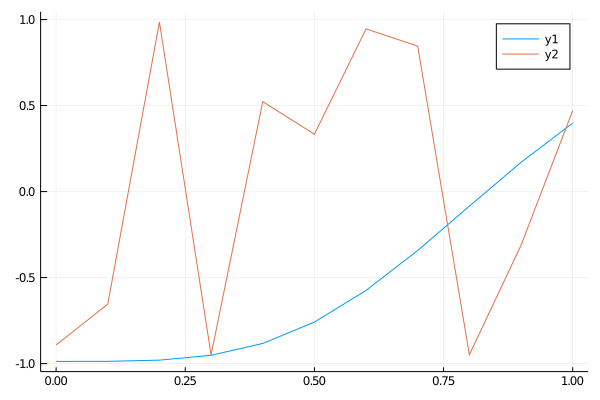

In [56]:
using Plots
max_ρ = 1
min_ρ = .0
ρs = range(min_ρ, max_ρ, step=max_ρ/10)
angle = π/2
target2 = [Real.(expect(sigmax(b), gaussian_spin_profile(ρ, angle))) for ρ in ρs]
y2s = [Real.(expect(sigmax(b), sequential_exact_evolution(ρ, angle))) for ρ in ρs];
plot(ρs, [target2, y2s])